<a href="https://colab.research.google.com/github/jackysiupuichung/breast-cancer-survival-binary-prediction/blob/main/breastcancer_binary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [277]:
import pandas as pd
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [278]:
!pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [279]:
random.seed(123)

In [280]:
zf = zipfile.ZipFile('breastcancer.zip') 
df = pd.read_csv(zf.open('METABRIC_RNA_Mutation.csv'))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


replace '' to NA

In [281]:
df.replace('', np.NaN)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


Problem statement: prediction of overall
survival (binary outcome, 0 or 1) using clincal clinical attributes

In [282]:
#extract clinical attributes
df_clinicalfeatures = df.iloc[:, :31]

In [283]:
#remove irrelevant attributes that do not contribute to survival  / death
excluded_clinicalfeatures = ['patient_id','cancer_type','death_from_cancer', 'oncotree_code', 'cohort', 'tumor_stage', 'overall_survival_months', '3-gene_classifier_subtype', 'er_status_measured_by_ihc', 'her2_status_measured_by_snp6']
df_clinicalfeatures = df_clinicalfeatures.drop(columns=excluded_clinicalfeatures)

In [284]:
#investigate missingness within df
percent_missing = df_clinicalfeatures.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df_clinicalfeatures.columns,
                                 'percent_missing': percent_missing})

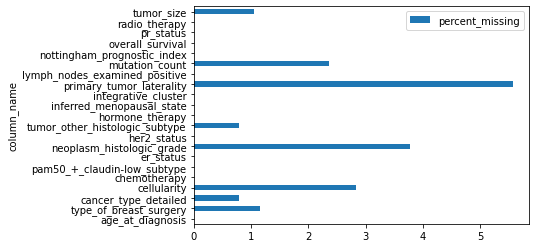

In [285]:
#if drop all rows with na 1600 samples remained
missing_value_df.plot.barh(x='column_name', y='percent_missing', rot=0)

filter out samples with unknown death_from_cancer which act as ground truth label

In [286]:
df_clinicalfeatures = df_clinicalfeatures[df_clinicalfeatures['overall_survival'].notna()]

convert categorical features to dummy variables

In [287]:
df_clinicalfeatures.dtypes

age_at_diagnosis                  float64
type_of_breast_surgery             object
cancer_type_detailed               object
cellularity                        object
chemotherapy                        int64
pam50_+_claudin-low_subtype        object
er_status                          object
neoplasm_histologic_grade         float64
her2_status                        object
tumor_other_histologic_subtype     object
hormone_therapy                     int64
inferred_menopausal_state          object
integrative_cluster                object
primary_tumor_laterality           object
lymph_nodes_examined_positive     float64
mutation_count                    float64
nottingham_prognostic_index       float64
overall_survival                    int64
pr_status                          object
radio_therapy                       int64
tumor_size                        float64
dtype: object

In [288]:
list_str_obj_cols = df_clinicalfeatures.columns[df_clinicalfeatures.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df_clinicalfeatures[str_obj_col] = df_clinicalfeatures[str_obj_col].astype("category")

In [289]:
df_clinicalfeatures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 1903
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   age_at_diagnosis                1904 non-null   float64 
 1   type_of_breast_surgery          1882 non-null   category
 2   cancer_type_detailed            1889 non-null   category
 3   cellularity                     1850 non-null   category
 4   chemotherapy                    1904 non-null   int64   
 5   pam50_+_claudin-low_subtype     1904 non-null   category
 6   er_status                       1904 non-null   category
 7   neoplasm_histologic_grade       1832 non-null   float64 
 8   her2_status                     1904 non-null   category
 9   tumor_other_histologic_subtype  1889 non-null   category
 10  hormone_therapy                 1904 non-null   int64   
 11  inferred_menopausal_state       1904 non-null   category
 12  integrative_cluster 

In [290]:
#extract categorical features
##evaluation: features such as cellularity has ordinal properties
categorical_features = df_clinicalfeatures.select_dtypes(['category']).columns.values.tolist()
categorical_features

['type_of_breast_surgery',
 'cancer_type_detailed',
 'cellularity',
 'pam50_+_claudin-low_subtype',
 'er_status',
 'her2_status',
 'tumor_other_histologic_subtype',
 'inferred_menopausal_state',
 'integrative_cluster',
 'primary_tumor_laterality',
 'pr_status']

for the categorical variables, they are converted to one hot encoding signal. This is preferable since the random forest imputation conducted later on will assume ordinal properties with e.g. [0, 1, 2, 3] labels in column with labelencoder. 

downside is that now features such as pr_status_Negative	pr_status_Positive are duplicated features

In [291]:
df_clinicalfeatures_cat = pd.get_dummies(df_clinicalfeatures, columns=categorical_features)

reason for conducting imputation: I think the sample to feature ratio is too low if simply remove samples with missing data values. This is commonlu done in genetic studies such as gwas and genomic selections to increase the power

In [292]:
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

# Make an instance and perform the imputation
imputer = MissForest()
X = df_clinicalfeatures_cat
X_imputed = imputer.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 0


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 3


In [293]:
df_clinicalfeatures_imputed = pd.DataFrame(X_imputed, columns = df_clinicalfeatures_cat.columns)

In [294]:
df_clinicalfeatures_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 57 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   age_at_diagnosis                                                1904 non-null   float64
 1   chemotherapy                                                    1904 non-null   float64
 2   neoplasm_histologic_grade                                       1904 non-null   float64
 3   hormone_therapy                                                 1904 non-null   float64
 4   lymph_nodes_examined_positive                                   1904 non-null   float64
 5   mutation_count                                                  1904 non-null   float64
 6   nottingham_prognostic_index                                     1904 non-null   float64
 7   overall_survival                                   

build model: Mixed effects logistic regression vs support vector machine (svm)

In [295]:
X = df_clinicalfeatures_imputed.drop(columns=['overall_survival'])
y = df_clinicalfeatures_imputed['overall_survival']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [296]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(1523, 56)
(190, 56)
(191, 56)
(1523,)
(190,)
(191,)


In [297]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter = 1000)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [298]:
from sklearn.metrics import classification_report
target_names = ['death', 'survival']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       death       0.75      0.76      0.75       112
    survival       0.65      0.63      0.64        79

    accuracy                           0.71       191
   macro avg       0.70      0.70      0.70       191
weighted avg       0.71      0.71      0.71       191



model with svm

In [299]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC()

In [300]:
from sklearn.metrics import classification_report
y_pred = svclassifier.predict(X_test)
target_names = ['death', 'survival']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       death       0.71      0.81      0.76       112
    survival       0.66      0.52      0.58        79

    accuracy                           0.69       191
   macro avg       0.68      0.67      0.67       191
weighted avg       0.69      0.69      0.68       191



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.731


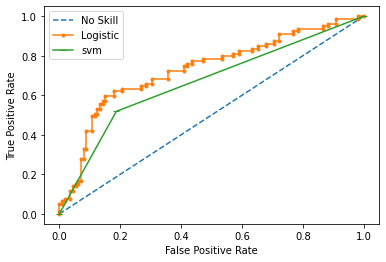

In [301]:
lr_probs = logreg.predict_proba(X_test)
ns_probs = [0 for _ in range(len(y_test))]
svm_pred = svclassifier.predict(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
#one-class SVM doesn't produce probability estimates for roc curves
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred)


# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(svm_fpr, svm_tpr, marker='_', label='svm')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

conclusion: the logistic regression outperformed the svm and baseline method.

extract feature importance in logistic regression prediction

In [302]:
importance = logreg.coef_[0]
features = X.columns.values.tolist()
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: age_at_diagnosis, Score: -0.07319
Feature: chemotherapy, Score: -0.06906
Feature: neoplasm_histologic_grade, Score: 0.10566
Feature: hormone_therapy, Score: 0.33016
Feature: lymph_nodes_examined_positive, Score: -0.08133
Feature: mutation_count, Score: -0.04586
Feature: nottingham_prognostic_index, Score: -0.16258
Feature: radio_therapy, Score: 0.37020
Feature: tumor_size, Score: -0.01300
Feature: type_of_breast_surgery_BREAST CONSERVING, Score: 0.10924
Feature: type_of_breast_surgery_MASTECTOMY, Score: -0.03724
Feature: cancer_type_detailed_Breast, Score: 0.53051
Feature: cancer_type_detailed_Breast Invasive Ductal Carcinoma, Score: -0.15299
Feature: cancer_type_detailed_Breast Invasive Lobular Carcinoma, Score: -0.04939
Feature: cancer_type_detailed_Breast Invasive Mixed Mucinous Carcinoma, Score: 0.27683
Feature: cancer_type_detailed_Breast Mixed Ductal and Lobular Carcinoma, Score: -0.18615
Feature: cancer_type_detailed_Metaplastic Breast Cancer, Score: -0.47116
Feature: c